In [60]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [61]:
import polars as pl
import numpy as np
from datetime import date
from silverfund.datasets import CRSPDaily
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
# Load dataset
df = (
    CRSPDaily(start_date=date(2010, 1, 1), end_date=date(2015, 12, 31))
    .load_all()
    .select(["permno", "ticker", "date", "shrout", "prc", "ret"])
)

df

permno,ticker,date,shrout,prc,ret
i64,str,date,f64,f64,f64
10001,"""EGAS""",2010-01-04,4361.0,10.25,-0.004854
10001,"""EGAS""",2010-01-05,4361.0,10.19,-0.005854
10001,"""EGAS""",2010-01-06,4361.0,10.31,0.011776
10001,"""EGAS""",2010-01-07,4361.0,9.96,-0.033948
10001,"""EGAS""",2010-01-08,4361.0,10.34,0.038153
…,…,…,…,…,…
93436,"""TSLA""",2015-12-24,130951.0,230.57001,0.003788
93436,"""TSLA""",2015-12-28,130951.0,228.95,-0.007026
93436,"""TSLA""",2015-12-29,130951.0,237.19,0.03599


In [ ]:
# Form momentum signal

# Log returns
df = df.with_columns(pl.col("ret").log1p().alias("logret"))

# Rolling sum from t-252 to t-22
df = df.with_columns(
    pl.col("logret")
    .rolling_sum(window_size=230, min_periods=230)
    .shift(22)
    .over("permno")
    .alias("mom")
)

df

permno,ticker,date,shrout,prc,ret,logret,mom
i64,str,date,f64,f64,f64,f64,f64
10001,"""EGAS""",2010-01-04,4361.0,10.25,-0.004854,-0.004866,null
10001,"""EGAS""",2010-01-05,4361.0,10.19,-0.005854,-0.005871,null
10001,"""EGAS""",2010-01-06,4361.0,10.31,0.011776,0.011707,null
10001,"""EGAS""",2010-01-07,4361.0,9.96,-0.033948,-0.034538,null
10001,"""EGAS""",2010-01-08,4361.0,10.34,0.038153,0.037443,null
…,…,…,…,…,…,…,…
93436,"""TSLA""",2015-12-24,130951.0,230.57001,0.003788,0.003781,-0.020501
93436,"""TSLA""",2015-12-28,130951.0,228.95,-0.007026,-0.007051,-0.042916
93436,"""TSLA""",2015-12-29,130951.0,237.19,0.03599,0.035357,0.017261


In [64]:
# Filters

# Price greater than 5
df = df.with_columns(pl.col("prc").shift(1).over("permno").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)

# Non-null momentum signal
df = df.drop_nulls(subset=["mom"])

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag
i64,str,date,f64,f64,f64,f64,f64,f64
10001,"""EGAS""",2010-12-31,7834.0,10.52,-0.00095,-0.00095,0.020476,10.53
10001,"""EGAS""",2011-01-03,7834.0,10.45,-0.006654,-0.006676,0.036238,10.52
10001,"""EGAS""",2011-01-04,7834.0,10.44,-0.000957,-0.000957,0.035188,10.45
10001,"""EGAS""",2011-01-05,7834.0,10.4,-0.003831,-0.003838,0.03923,10.44
10001,"""EGAS""",2011-01-06,7834.0,10.43,0.002885,0.002881,0.078638,10.4
…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2015-12-24,130951.0,230.57001,0.003788,0.003781,-0.020501,229.7
93436,"""TSLA""",2015-12-28,130951.0,228.95,-0.007026,-0.007051,-0.042916,230.57001
93436,"""TSLA""",2015-12-29,130951.0,237.19,0.03599,0.035357,0.017261,228.95


In [65]:
# Create portfolio bins

labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("mom").qcut(10, labels=labels).over("date").alias("bin"))

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag,bin
i64,str,date,f64,f64,f64,f64,f64,f64,cat
10001,"""EGAS""",2010-12-31,7834.0,10.52,-0.00095,-0.00095,0.020476,10.53,"""3"""
10001,"""EGAS""",2011-01-03,7834.0,10.45,-0.006654,-0.006676,0.036238,10.52,"""3"""
10001,"""EGAS""",2011-01-04,7834.0,10.44,-0.000957,-0.000957,0.035188,10.45,"""3"""
10001,"""EGAS""",2011-01-05,7834.0,10.4,-0.003831,-0.003838,0.03923,10.44,"""3"""
10001,"""EGAS""",2011-01-06,7834.0,10.43,0.002885,0.002881,0.078638,10.4,"""3"""
…,…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2015-12-24,130951.0,230.57001,0.003788,0.003781,-0.020501,229.7,"""4"""
93436,"""TSLA""",2015-12-28,130951.0,228.95,-0.007026,-0.007051,-0.042916,230.57001,"""4"""
93436,"""TSLA""",2015-12-29,130951.0,237.19,0.03599,0.035357,0.017261,228.95,"""5"""


In [66]:
# Create portfolio returns dataframe

# Aggregate (equal weight portfolios)
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())

# Pivot
port = port.pivot(on="bin", index="date", values="ret")

# Reorder columns
port = port.select(["date"] + labels)

# Sort
port = port.sort(by="date")

port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-12-31,-0.00258,-0.003468,-0.00485,-0.003545,-0.005307,-0.00334,-0.003627,-0.002834,-0.004916,-0.004043
2011-01-03,0.019215,0.017336,0.01665,0.012311,0.013108,0.01124,0.013084,0.016233,0.014905,0.017113
2011-01-04,-0.008943,-0.011693,-0.011335,-0.010525,-0.011358,-0.01271,-0.011252,-0.013577,-0.014257,-0.011716
2011-01-05,0.011143,0.008222,0.009205,0.009031,0.006779,0.009302,0.01043,0.010179,0.009933,0.016254
2011-01-06,-0.001072,-0.001713,-0.001817,-0.004488,-0.003663,-0.00485,-0.001962,-0.003239,-0.003997,-0.00254
…,…,…,…,…,…,…,…,…,…,…
2015-12-24,0.001534,0.002208,0.000728,0.001819,0.000056,0.001473,0.002208,0.002346,0.001737,0.001397
2015-12-28,-0.024158,-0.011985,-0.007086,-0.006461,-0.003682,-0.005481,-0.002365,-0.001763,-0.003781,-0.00387
2015-12-29,0.008203,0.008083,0.007654,0.010475,0.010567,0.009914,0.010524,0.010101,0.010494,0.012644


In [67]:
# Create spread portfolio

port = port.with_columns((pl.col("9") - pl.col("0")).alias("spread"))

port

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-12-31,-0.00258,-0.003468,-0.00485,-0.003545,-0.005307,-0.00334,-0.003627,-0.002834,-0.004916,-0.004043,-0.001462
2011-01-03,0.019215,0.017336,0.01665,0.012311,0.013108,0.01124,0.013084,0.016233,0.014905,0.017113,-0.002103
2011-01-04,-0.008943,-0.011693,-0.011335,-0.010525,-0.011358,-0.01271,-0.011252,-0.013577,-0.014257,-0.011716,-0.002772
2011-01-05,0.011143,0.008222,0.009205,0.009031,0.006779,0.009302,0.01043,0.010179,0.009933,0.016254,0.005111
2011-01-06,-0.001072,-0.001713,-0.001817,-0.004488,-0.003663,-0.00485,-0.001962,-0.003239,-0.003997,-0.00254,-0.001468
…,…,…,…,…,…,…,…,…,…,…,…
2015-12-24,0.001534,0.002208,0.000728,0.001819,0.000056,0.001473,0.002208,0.002346,0.001737,0.001397,-0.000137
2015-12-28,-0.024158,-0.011985,-0.007086,-0.006461,-0.003682,-0.005481,-0.002365,-0.001763,-0.003781,-0.00387,0.020288
2015-12-29,0.008203,0.008083,0.007654,0.010475,0.010567,0.009914,0.010524,0.010101,0.010494,0.012644,0.004442


In [68]:
# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])

port

date,bin,ret
date,str,f64
2010-12-31,"""0""",-0.00258
2010-12-31,"""1""",-0.003468
2010-12-31,"""2""",-0.00485
2010-12-31,"""3""",-0.003545
2010-12-31,"""4""",-0.005307
…,…,…
2015-12-31,"""6""",-0.010012
2015-12-31,"""7""",-0.010149
2015-12-31,"""8""",-0.009617


In [69]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(
    ((pl.col("mean") * 252) / (pl.col("std") * np.sqrt(252)))
    .cast(pl.Float64)
    .alias("annualized_sharpe")
)

# Tstat
result = result.with_columns(
    (pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat")
)

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Daily results")
result

Daily results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",-0.000005,0.000414,0.000522,0.000636,0.000591,0.00062,0.000669,0.000665,0.000613,0.000596,0.000601
"""std""",0.01439,0.012164,0.011284,0.010806,0.010522,0.010479,0.010677,0.011098,0.011714,0.013921,0.008915
"""count""",1259.0,1259.0,1259.0,1259.0,1259.0,1259.0,1259.0,1259.0,1259.0,1259.0,1259.0
"""annualized_sharpe""",-0.005871,0.540687,0.734815,0.934927,0.892135,0.939818,0.994423,0.951606,0.830414,0.679728,1.070853
"""tstat""",-0.013122,1.208532,1.642445,2.089731,1.994082,2.100662,2.222714,2.127011,1.856125,1.519314,2.39355


In [70]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
2010-12-31,"""0""",-0.00258,-0.002584,-0.258379
2010-12-31,"""1""",-0.003468,-0.003474,-0.347402
2010-12-31,"""2""",-0.00485,-0.004861,-0.486143
2010-12-31,"""3""",-0.003545,-0.003551,-0.35514
2010-12-31,"""4""",-0.005307,-0.005321,-0.532109
…,…,…,…,…
2015-12-31,"""6""",-0.010012,-0.010063,76.995157
2015-12-31,"""7""",-0.010149,-0.010201,75.965276
2015-12-31,"""8""",-0.009617,-0.009663,68.465883


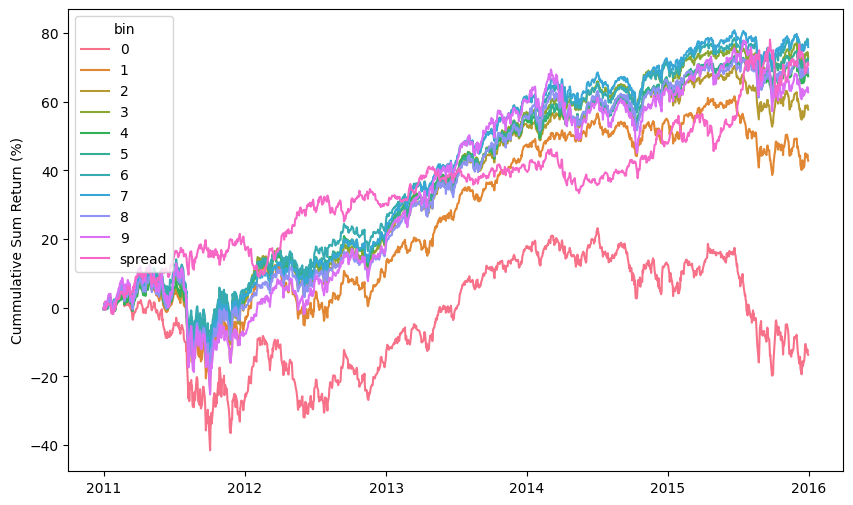

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(port, x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

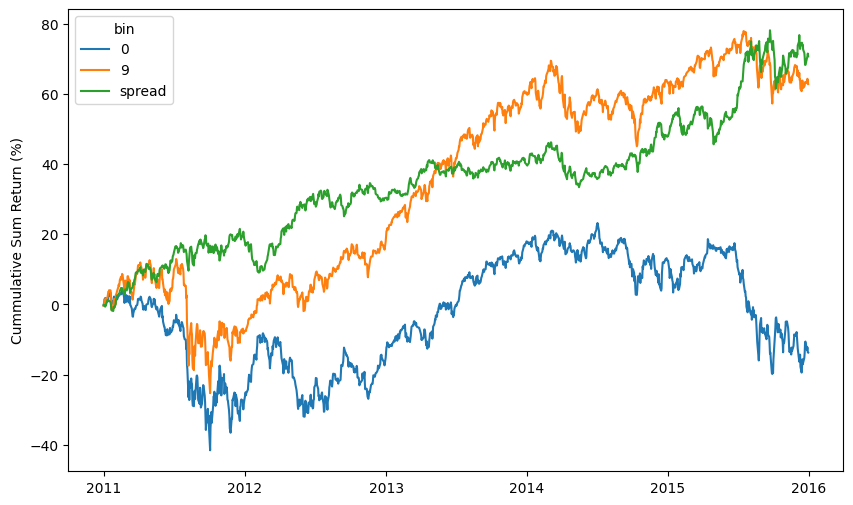

In [72]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin"
)
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

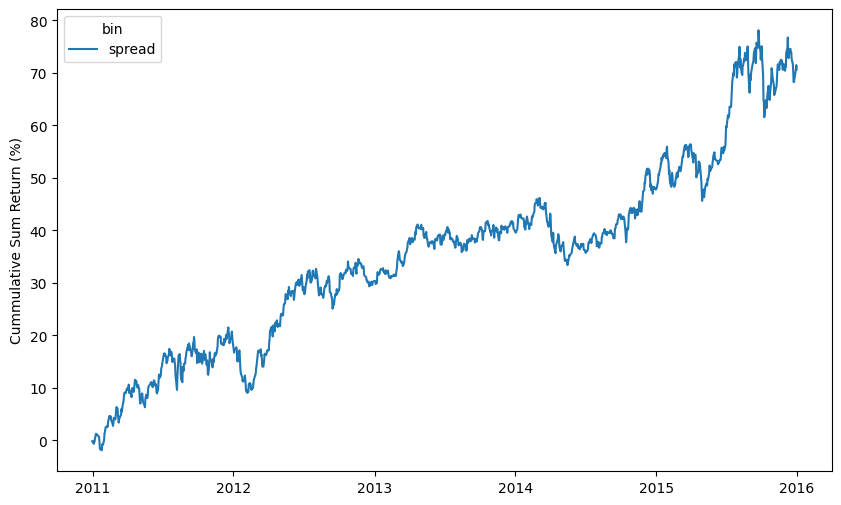

In [73]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin") == "spread"), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

In [74]:
min_date = port["date"].min().strftime("%Y-%m-%d")
max_date = port["date"].max().strftime("%Y-%m-%d")

print(f"From {min_date} to {max_date}")

From 2010-12-31 to 2015-12-31
